In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 8)

#  Boosting

Бустинг представляет собой жадный алгоритм построения композиции алгоритмов. Основная идея заключается в том, чтобы, имея множество относительно слабых алгоритмов обучения, построить их хорошую линейную комбинацию. Он похож на бэггинг тем, что базовый алгоритм обучения фиксирован. Отличие состоит в том, что обучение базовых алгоритмов для композиции происходит итеративно, и каждый следующий алгоритм стремится компенсировать недостатки композиции всех предыдущих алгоритмов.

На примере бустинга стало ясно, что хорошим качеством могут обладать сколь угодно сложные композиции классификаторов, при условии, что они правильно настраиваются. Это развеяло существовавшие долгое время представления о том, что для повышения обобщающей способности необходимо ограничивать сложность алгоритмов. 

Впоследствии этот феномен бустинга получил теоретическое обоснование. Оказалось, что взвешенное голосование не увеличивает эффективную сложность алгоритма, а лишь сглаживает ответы базовых алгоритмов. Эффективность бустинга объясняется тем, что по мере добавления базовых алгоритмов увеличиваются отступы обучающих объектов. Причём бустинг продолжает раздвигать классы даже после достижения безошибочной классификации обучающей выборки.

Общая схема бустинга:
- Искомый ансамбль алгоритмов имеет вид $a(x) = \mbox{sign}(\sum_{t = 1}^T \alpha_t b_t(x))$, где $b_t$ - базовые алгоритмы.
- Ансамбль строится итеративно, оптимизируя на каждом шаге функционал $Q_t$, равный количеству ошибок текущей композиции на обучающей выборке.
- При добавлении слагаемого $\alpha_t b_t(x)$ в сумму, функционал $Q_t$ оптимизируется только по базовому алгоритму $b_t(x)$ и коэффициенту $\alpha_t$ при нём, все предыдущие слагаемые считаются фиксированными.
- Функционал $Q_t$ имеет вид суммы по объектам обучающей выборки пороговых функций вида $[y_i \sum_{j = 1}^t \alpha_j b_j(x_i) < 0]$, имеющих смысл "текущая композиция ошибается на объекте с номером $i$". Каждое такое слагаемое имеет вид "ступеньки" и является разрывной функцией. Для упрощения решения задачи оптимизации такая пороговая функция заменяется на непрерывно дифференцируемую оценку сверху. В итоге получается новый функционал $\hat{Q}_t \geqslant Q_t$, минимизация которого приводит к минимизации исходного функционала $Q_t$.

Используя различные аппроксимации для пороговой функции потерь $[z < 0]$, будем получать различные виды бустинга. Примеры:
- $e^{-z}$ - AdaBoost
- $\log_2(1 + e^{-z})$ - LogitBoost
- $(1 - z)^2$ - GentleBoost
- $e^{-cz(z+a)}$ - BrownBoost
- другие

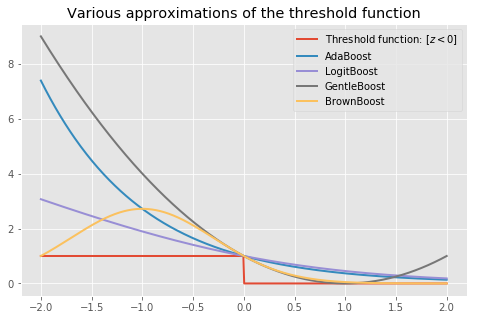

In [2]:
x = np.linspace(-2, 2, 500)

plt.figure(figsize=(8,5))
plt.plot(x, x < 0, lw=2, label='Threshold function: $[z < 0]$')
plt.plot(x, np.exp(-x), lw=2, label='AdaBoost')
plt.plot(x, np.log2(1 + np.exp(-x)), lw=2, label='LogitBoost')
plt.plot(x, (1 - x) ** 2, lw=2, label='GentleBoost')
plt.plot(x, np.exp(-x * (x + 2)), lw=2, label='BrownBoost')
plt.title('Various approximations of the threshold function')
plt.legend(loc='best')

# Aлгоритм Ada-boost

## Повторяем теорию

Boosting, в отличие от bagging'а - это последовательный способ построения композиции базовых моделей.

Мы постоянно работаем с одним и тем же набором данных, **но** на каждом шаге строим новую базовую модель, которая учитывает ошибки предыдущей модели.<br\>По большому счету, бустинг-алгоритмы отличаются лишь тем, как в них заложен учет этих самых ошибок.

Например в методе AdaBoost каждому объекту присваивается вес, который изменяется в зависимости от того, ошиблась ли на нем очередная композиция базовых алгоритмов или нет. Так же веса имеются и у самих базовых моделей, которые штрафуют их за плохие предсказания. Для задачи классификации этот процесс можно проиллюстрировать следующим образом:

<img src='https://s9.postimg.org/lq3lethhr/boosting.png' width='650'>

Введем следующие обозначения:
* $t_k$ - базовый классификатор, полученный на шаге $k$
* $\alpha_k$ - вес базового классификатора, полученного на шаге $k$
* $w_k(i)$ - веса объектов на шаге $k$
* $x_i$ - $i$-й объект, $i = 1, \dots, N$
* $y_i=\{-1, 1\}$ - метки класса для $i$-го объекта 

Конечное предсказание получается из взвешенной комбинации предсказания базовых моделей:
$$ T(x^*) = sign(\sum\limits^{K}_{k=1}\alpha_kt_k(x^*)) $$

Наша цель - минимизировать количество ошибок на всей выборке ..

$$ E_T = \frac{1}{N}\sum\limits_{i=1}^N [T(x_i) \neq y_i] $$

.. которые мы мажорируем экспонентой =)

$$ E_T = \frac{1}{N}\sum\limits_{i=1}^N [T(x_i) \neq y_i] \leq \frac{1}{N}\sum\limits_{i=1}^N e^{(-y_i\sum_k\alpha_kt_k(x_i))} $$

Если мы посчитаем ошибки $E_1, E_2, E_3,...$ на каждом шаге, то это даст нам правило для обновления весов объектов. (Упражнение)<br\>
А если мы посчитаем ошибки производную $E_t$ по $\alpha_t$, то это даст нам правило для обновления весов базовых моделей. (Упражнение)<br\>

Алгоритм обучения **Discrete AdaBoost**:

* Инициализируем веса объектов $w(i)_1 = \frac{1}{N}$ 
* Для $k = 1..K$
    * Обучить классификатор $t_k(x) \in \{-1, 1\}$ используя веса объектов $w(i)_k$
    * Вычислить ошибку взвешенную ошибку $\epsilon = \frac{\sum_i w_{k}(i)[y_i \neq t_k(x_i) ]}{\sum_i w_{k}(i)}$
    * Вычислить вес базовой модели $\alpha_k = \ln\frac{1-\epsilon}{\epsilon}$
    * Пересчитать веса объектов $w_{k+1}(i) = \frac{w_{k}(i) e^{-\alpha_k y_i t_k(x_i)}}{W}$, $i = 1, \dots, N$,где $W = \sum_i w_k(i) e^{-\alpha_k y_i t_k(x_i)}$ - нормировочная константа.
* $T(x) = sign(\sum_k \alpha_k t_k(x))$

Можно вывести аналогичный алгоритм для задачи регрессии.

*Обратите внимание* что базовые модели как правило явлюятся слабыми (weak learners), т.е. их качество должно едва ли превышать бросание монетки. На рисунке выше - это логические правила на одном из признаков, что равносильно дереву решений с глубиной 1.

<img src="boosting_overfitting.png">

## Игрушечная практика

In [4]:
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

Рассмотрим такой набор данных

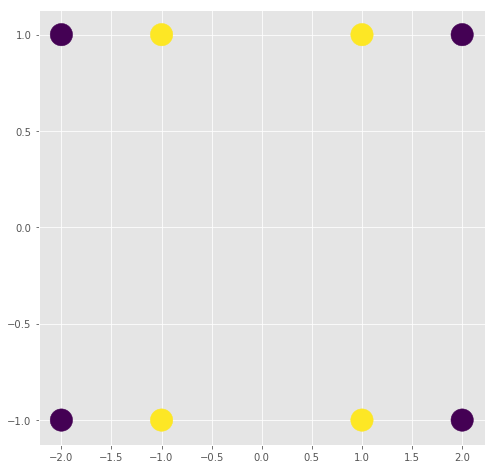

In [5]:
X = np.array([[-2, -1], [-2, 1], [2, -1], [2, 1], [-1, -1], [-1, 1], [1, -1], [1, 1]])
y = np.array([-1,-1,-1,-1,1,1,1,1])

plt.scatter(X[:, 0], X[:, 1], c=y, s=500)

**Вопрос:** Cколько базовых классификаторов достаточно, чтобы правильно классифицировать эти данные?

Запомнили ответ, а теперь посмотрим

In [6]:
def plot_decision(model, rows=1, columns=3):
    fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(15,4))
    ax = ax.ravel()

    xx1, xx2 = np.meshgrid(np.arange(X[:,0].min()-1, X[:,0].max()+1, 0.1),
                           np.arange(X[:,1].min()-1, X[:,1].max()+1, 0.1)) #сетка координат

    yy = model.staged_predict(np.c_[xx1.ravel(), xx2.ravel()]) #стадия, множество ответов на определенной операции
    #последний - реальный ответ

    for i, y_hat in enumerate(yy):
        y_hat = y_hat.reshape(xx1.shape)

        ax[i].set_title('iteration %d' % (i+1))
        ax[i].contourf(xx1, xx2, y_hat, cmap=plt.cm.Paired)
        ax[i].scatter(X[:, 0], X[:, 1], c=y, s=300)

In [6]:
# on tree max_length = 1

In [13]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=3,algorithm='SAMME')
ada.fit(X,y)
#algorith - как вычисляется вес ошибки (есть или нет/определенность классификатора)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=3, random_state=None)

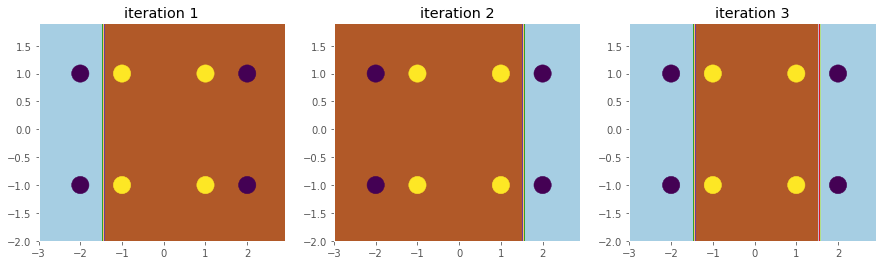

In [14]:
 plot_decision(ada)

# Градиентный бустинг

## Повторяем теорию

Основная идея градиентного бустинга заключается в том, что каждая следующая базовая модель настраивается на "остатки" предыдущих базовых моделей.
По своей структуре метод похож на алгоритм градиентного спуска - отсюда и такое название.

Пусть дана дифференцируемая функция потерь $L(t_k(x), y)$. Алгоритм выглядит следующим образом:
* Инициализируем композицию константным значением $t_0(x) = \arg\min_{C} \sum_{i=1}^n L(C, y_i)$.
* Для всех $k = 1, \dots, K$:
    * Вычислить "остатки" предыдущей композиции: $r_t(i) = -\frac{\partial L(t_k(x_i), y_i)}{\partial t_{k-1}(x_i)}, i = 1, \dots, N$.
    * Настроить базовую модель $t_k(x)$ на полученные остатки, т.е. обучить его по выборке $\{(x_i, r_t(i)), i = 1, \dots, N\}$.
    * Вычислить коэффициент $\alpha_k$ перед базовым алгоритмом $t_k(x)$ как решение следующей одномерной задачи оптимизации:
    $\alpha_k = \arg\min_\alpha \sum_{i=1}^N L(t_{k-1}(x_i) + \alpha t_k(x_i), y_i)$.<br\>
    (Иногда $\alpha_k$ задается вручную)
    * Добавить полученное слагаемое в композицию: $t_k(x) = t_{k-1}(x) + \alpha_k t_k(x)$.
   
Для задач регресси обычно использую квадратичную функцию потерь или модуль отклонения.<br\>
В задаче классификации используется логистическая функция потерь, которая позволяет возвращать вероятности принадлежности объектов к классам.

Наибольший успех, а потому и популярность, получил градиентный бустинг на деревьях решений. Именно с этой его реализацией мы сейчас поработаем

## Игрушечная практика

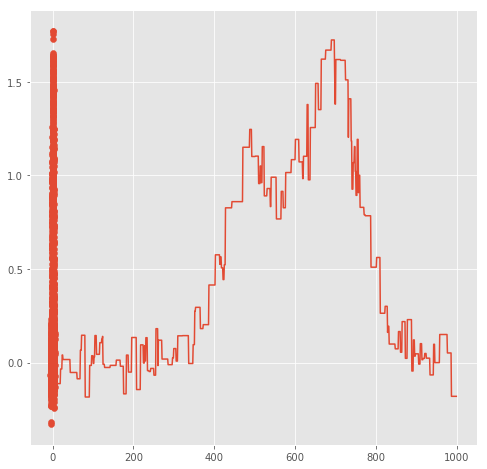

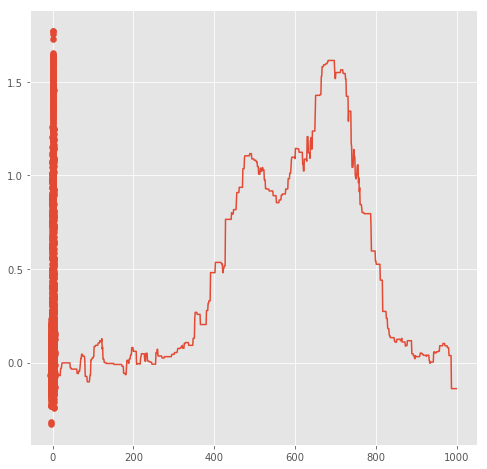

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
     
n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
    # http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.ravel.html 
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) +\
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)
# One decision tree regressor
dtree = DecisionTreeRegressor()
dtree.fit(X_train,y_train)
y_pred_dtree = dtree.predict(X_test)
# learn and predict

# plot real function and descision, scatter points and calc MSE
plt.scatter(X_test,y_test)
plt.plot(y_pred_dtree)
plt.show()

gbtree = GradientBoostingRegressor(n_estimators=100, subsample=0.5)
gbtree.fit(X_train,y_train)
y_pred_gbtree = gbtree.predict(X_test)
# learn predict

# plot real function and descision, scatter points and calc MSE
plt.scatter(X_test,y_test)
plt.plot(y_pred_gbtree)
plt.show()

## Пример с поэтапным приближением

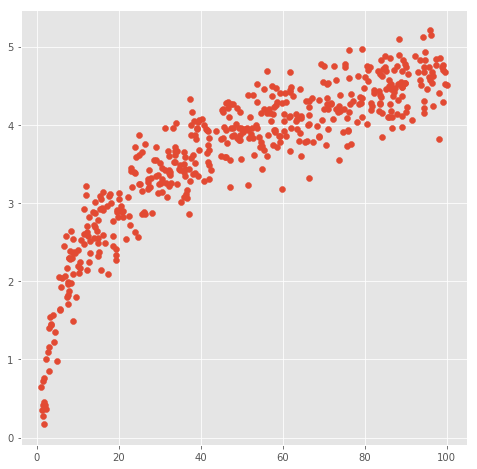

In [34]:
X = np.random.uniform(1, 100, 500)

y = np.log(X) + np.random.normal(0, .3, 500)
plt.scatter(X, y)

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

TypeError: 'module' object is not callable

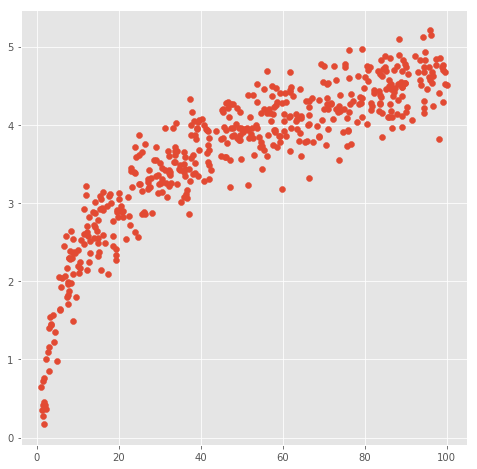

In [39]:
# Обучите модель и изобразите предсказания на каждом шаге
# Посмотрите, как влияет скорость обучения learning_rate на предсказания
gbreg = GradientBoostingRegressor()
gbreg.fit(X.reshape(-1,1),y)
plt.scatter(X,y)
lst = gbreg.staged_predict(X.reshape(-1,1))
for i in lst:
    plt(i)

# Настоящая практика

Один из самых важных параметров алгоритма бустинга является количество базовых моделей.<br\>
Слишком большое количество моделей может привести к переобучению, а слишком малое - к недообучению.<br\>
Как бы вы определяли оптимальное количество базовых моделей?

Рассмотрите данные из датасета california.dat. По этой таблице предлагается построить модель, предсказывающую стоимоть дома в калифорнии по остальным прихнакам.

* Загрузите данные и разбейте их на обучающую и контрольную выбору
* Определите оптимальное количество базовых моделей в градиентном бустинге
* Посмотрите, как ваш ответ меняется при изменении скорости обучения
* В качестве ошибки используйте MAE

In [9]:
#head california.dat

# Полезные ссылки
- [Лекция](http://www.machinelearning.ru/wiki/images/c/cd/Voron-ML-Compositions-slides.pdf) К.В. Воронцова по композиционным методам классификации
- <a href="https://github.com/dmlc/xgboost">Xgboost</a> - Пробуем на Azure
  * Для ИАД-1 https://minor1.eastus.cloudapp.azure.com:8000/hub/login  (userX 634a1320e370)
  * Для ИАД-2 https://minor2.eastus.cloudapp.azure.com:8000/hub/login  (userY 21287736acbb)
- <a href="https://github.com/ChenglongChen/Kaggle_CrowdFlower">Обзор</a> решения победителя соревнования Kaggle "CrowdFlower" по предсказанию релевантности выдачи поисковика товаров. Решение на основе Xgboost

In [ ]:
#user: user2
#password: 21287736acbb